In [1]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [2]:
! pip install -q kaggle
files.upload() #upload kaggle.json file
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
def downloadKaggleData(link):
  name = (link.split(' ')[-1]).split('/')[-1]
  ! {link}
  ! mkdir {name}
  ! unzip {name}.zip -d {name}
downloadKaggleData("kaggle competitions download -c house-prices-advanced-regression-techniques")

100% 199k/199k [00:00<00:00, 504kB/s]
100% 199k/199k [00:00<00:00, 504kB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: house-prices-advanced-regression-techniques/data_description.txt  
  inflating: house-prices-advanced-regression-techniques/sample_submission.csv  
  inflating: house-prices-advanced-regression-techniques/test.csv  
  inflating: house-prices-advanced-regression-techniques/train.csv  


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
from sklearn.preprocessing import OneHotEncoder

class TrainDataset(Dataset):
  def __init__(self, dataLink):
    #Data cleaning taken from https://www.geeksforgeeks.org/house-price-prediction-using-machine-learning-in-python/
    #with some improvement by me (Ryan) inspired from https://www.kaggle.com/code/srivignesh/data-preprocessing-for-house-price-prediction
    dataset = pd.read_csv(dataLink)

    #Drop unnecessary ID column
    dataset.drop(['Id'],
             axis=1,
             inplace=True)

    #Fill in nan in saleprice
    dataset['SalePrice'] = dataset['SalePrice'].fillna(dataset['SalePrice'].mean())

    #Drop columns with more than 70% nan
    column_with_multiple_nans = dataset.isnull().sum() > 0.7 * dataset.shape[0]
    column_with_multiple_nans = list(column_with_multiple_nans[column_with_multiple_nans].index)
    dataset = dataset.drop(column_with_multiple_nans, axis=1)

    #Fill nan for the rest of the dataset
    for col in dataset:
        dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

    #opposite of several cold decoder
    s = (dataset.dtypes == 'object')
    object_cols = list(s[s].index)
    label_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    label_encoded_columns = pd.DataFrame(label_encoder.fit_transform(dataset[object_cols]))
    label_encoded_columns.columns = label_encoder.get_feature_names_out()
    dataset = dataset.drop(object_cols, axis=1)
    dataset = pd.concat([dataset, label_encoded_columns], axis=1)


    self.x = dataset.drop('SalePrice', axis=1)
    self.y = dataset['SalePrice']
    self.x = torch.tensor(self.x.values, dtype=torch.float32)
    self.y = torch.tensor(self.y.values, dtype=torch.float32)

    self.y = self.y.reshape(-1, 1)

  def __len__(self):
    return self.x.shape[0]
  def __getitem__(self, ind):
    x = self.x[ind]
    y = self.y[ind] / 100000
    return x, y

train_set = TrainDataset("house-prices-advanced-regression-techniques/train.csv")
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, test_set = random_split(train_set, [train_size, val_size])


batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
print(train_set[0])

Shape of X [N, C, H, W]: torch.Size([128, 274]) torch.float32
Shape of y: torch.Size([128, 1]) torch.float32
(tensor([1.9000e+02, 6.0000e+01, 1.1340e+04, 4.0000e+00, 6.0000e+00, 1.8850e+03,
        1.9500e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.7700e+02, 7.7700e+02,
        1.2460e+03, 1.0440e+03, 0.0000e+00, 2.2900e+03, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 4.0000e+00, 2.0000e+00, 1.1000e+01, 0.0000e+00,
        1.9710e+03, 2.0000e+00, 5.6000e+02, 0.0000e+00, 0.0000e+00, 1.1400e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 2.0100e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.

In [5]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

class MLP(nn.Module):
  def __init__(self) -> None:
    super(MLP, self).__init__()
    inputlayer = [274]
    hiddenlayer = [1024,512,64]
    outputlayer = 1
    hiddenlayer = inputlayer + hiddenlayer

    self.layers = nn.Sequential()
    for i in range(len(hiddenlayer)-1):
      self.layers.add_module(f'linear_{i+1}', nn.Linear(hiddenlayer[i], hiddenlayer[i+1]))
      self.layers.add_module(f'relu_{i+1}', nn.ReLU())
    self.layers.add_module(f'linear_last', nn.Linear(hiddenlayer[-1], outputlayer))

  def forward(self, x):
    x = x.float()
    return self.layers(x)

model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
print(model)

Using cpu device
MLP(
  (layers): Sequential(
    (linear_1): Linear(in_features=274, out_features=1024, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=1024, out_features=512, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=512, out_features=64, bias=True)
    (relu_3): ReLU()
    (linear_last): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [6]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()

  num_batches = len(dataloader)
  num_items = len(dataloader.dataset)

  total_loss = 0
  total_correct = 0

  losses = []
  for batch_num, (X, y) in enumerate(dataloader):
    optimizer.zero_grad()
    X, y = X.to(device), y.to(device)
    output = model(X)
    loss = loss_fn(output, y)
    total_loss += loss.item()
    loss.backward()
    losses.append(loss.item())
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

  train_loss = total_loss/num_batches
  return train_loss


In [7]:
def test(dataloader, model, loss_fn):
  model.eval()

  num_batches = len(dataloader)
  num_items = len(dataloader.dataset)
  total_loss = 0
  total_correct = 0

  losses = []

  with torch.no_grad():
    for batch_num, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      output = model(X)

      loss = loss_fn(output, y)

      total_loss += loss
      losses.append(loss.item())

  test_loss = total_loss/num_batches
  return test_loss

In [8]:
epochs = 20
trainloss = []
testloss = []

for epoch in range(epochs):
    trainloss.append(train(train_loader, model, criterion, optimizer))
    testloss.append(test(test_loader, model, criterion))

KeyboardInterrupt: 

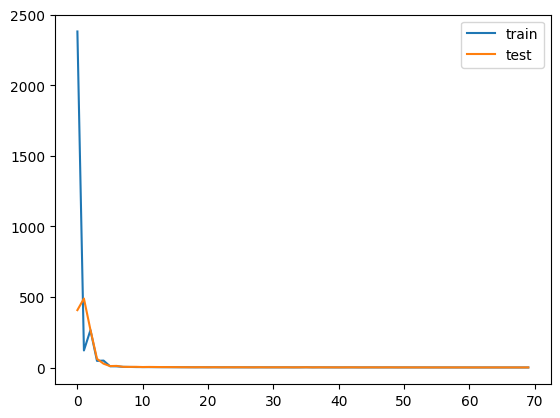

In [10]:
trainpoints = np.array(trainloss)
testpoints = np.array(testloss)
plt.plot(trainpoints, label='train')
plt.plot(testpoints, label='test')
plt.legend()
plt.show()